[PV education article](https://www.pveducation.org/pvcdrom/solar-cell-operation/iv-curve#footnote1_zlgyr9m)


In [25]:
from numpy import array, arange, exp
from math import factorial
from scipy.optimize import curve_fit
from matplotlib.pyplot import scatter, plot, show
from scipy.constants import Boltzmann, elementary_charge

Simplified expression:

$ I(V) = I_L + I_S \ e^{ ( \frac{qV}{nkT} ) } $

In [26]:
V = array([11.8, 10.6, 10.5, 10.1, 5.9, 3.1, 2.1, 1.6])
I = array([0.00, 0.29, 0.42, 0.46, 0.49, 0.52, 0.53, 0.53])

n = 1.0			# ideality factor
k = Boltzmann 			# joules per kelvin
q = elementary_charge 	# couloumbs
T = 300.0 				# kelvin

def objective_real(x, I_L, I_S, n):
	return I_L - I_S * ( exp(q*x / (n*k*T)) ) 

The above equation _should_ work, but the python non-linear least squares algorithm is unable to calculate the covariance matrix on the function `exp()`. 

So we need to do a taylor expansion of $e^x$:

$
e^x = 1 + x/1! + x^2/2! + x^3/3! ...
$

In [33]:
def objective(x, I_L, I_S):
	taylor = 1
	for i in range(1,10):
		taylor += (q*x / (n*k*T))**i/factorial(i)
	return I_L - I_S * taylor	

In [34]:
# curve fit
parameters, _ = curve_fit(objective, V, I)

I_L = 0.5319299161504669
I_S = 2.1195126133207896e-19


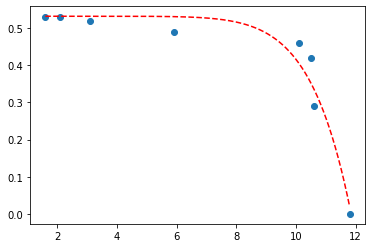

In [35]:
# summarize the parameter values
I_L, I_S = parameters
print(f'I_L = {I_L}')
print(f'I_S = {I_S}')

# plot input vs output
scatter(V, I)

# define a sequence of inputs between the smallest and largest known inputs
x_line = arange(min(V), max(V), .01)

# calculate the output for the range
y_line = objective(x_line, I_L, I_S)

# create a line plot for the mapping function
plot(x_line, y_line, '--', color='red')
show()